# Wasserstein GAN with Gradient Penalty (WGAN-GP)

### Goals
In this notebook, you're going to build a Wasserstein GAN with Gradient Penalty (WGAN-GP) that solves some of the stability issues with the GANs that you have been using up until this point. Specifically, you'll use a special kind of loss function known as the W-loss, where W stands for Wasserstein, and gradient penalties to prevent mode collapse.

*Fun Fact: Wasserstein is named after a mathematician at Penn State, Leonid Vaseršteĭn. You'll see it abbreviated to W (e.g. WGAN, W-loss, W-distance).*

### Learning Objectives
1.   Get hands-on experience building a more stable GAN: Wasserstein GAN with Gradient Penalty (WGAN-GP).
2.   Train the more advanced WGAN-GP model.



## Generator and Critic

You will begin by importing some useful packages, defining visualization functions, building the generator, and building the critic. Since the changes for WGAN-GP are done to the loss function during training, you can simply reuse your previous GAN code for the generator and critic class. Remember that in WGAN-GP, you no longer use a discriminator that classifies fake and real as 0 and 1 but rather a critic that scores images with real numbers.

#### Packages and Visualizations

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

def make_grad_hook():
    '''
    Function to keep track of gradients for visualization purposes, 
    which fills the grads list when using model.apply(grad_hook).
    '''
    grads = []
    def grad_hook(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            grads.append(m.weight.grad)
    return grads, grad_hook

#### Generator and Noise

In [2]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
      n_samples: the number of samples to generate, a scalar
      z_dim: the dimension of the noise vector, a scalar
      device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

#### Critic

In [3]:
class Critic(nn.Module):
    '''
    Critic Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=64):
        super(Critic, self).__init__()
        self.crit = nn.Sequential(
            self.make_crit_block(im_chan, hidden_dim),
            self.make_crit_block(hidden_dim, hidden_dim * 2),
            self.make_crit_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_crit_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a critic block of DCGAN;
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the critic: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)
        '''
        crit_pred = self.crit(image)
        return crit_pred.view(len(crit_pred), -1)

## Training Initializations
Now you can start putting it all together.
As usual, you will start by setting the parameters:
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   beta_1, beta_2: the momentum terms
  *   c_lambda: weight of the gradient penalty
  *   crit_repeats: number of times to update the critic per generator update - there are more details about this in the *Putting It All Together* section
  *   device: the device type

You will also load and transform the MNIST dataset to tensors.




In [4]:
n_epochs = 100
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 5
device = 'cuda'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=False, transform=transform),
    batch_size=batch_size,
    shuffle=True)

Then, you can initialize your generator, critic, and optimizers.

In [5]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit = Critic().to(device) 
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)


## Gradient Penalty
Calculating the gradient penalty can be broken into two functions: (1) compute the gradient with respect to the images and (2) compute the gradient penalty given the gradient.

You can start by getting the gradient. The gradient is computed by first creating a mixed image. This is done by weighing the fake and real image using epsilon and then adding them together. Once you have the intermediate image, you can get the critic's output on the image. Finally, you compute the gradient of the critic score's on the mixed images (output) with respect to the pixels of the mixed images (input). You will need to fill in the code to get the gradient wherever you see *None*. There is a test function in the next block for you to test your solution.

In [6]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_gradient
def get_gradient(crit, real, fake, epsilon):
    '''
    Return the gradient of the critic's scores with respect to mixes of real and fake images.
    Parameters:
        crit: the critic model
        real: a batch of real images
        fake: a batch of fake images
        epsilon: a vector of the uniformly random proportions of real/fake per mixed image
    Returns:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    '''
    # Mix the images together
    mixed_images = real * epsilon + fake * (1 - epsilon)

    # Calculate the critic's scores on the mixed images
    mixed_scores = crit(mixed_images)
    
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        # Note: You need to take the gradient of outputs with respect to inputs.
        # This documentation may be useful, but it should not be necessary:
        # https://pytorch.org/docs/stable/autograd.html#torch.autograd.grad
        #### START CODE HERE ####
        inputs=mixed_images,
        outputs=mixed_scores,
        #### END CODE HERE ####
        # These other parameters have to do with the pytorch autograd engine works
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient


In [7]:
# UNIT TEST
# DO NOT MODIFY THIS
def test_get_gradient(image_shape):
    real = torch.randn(*image_shape, device=device) + 1
    fake = torch.randn(*image_shape, device=device) - 1
    epsilon_shape = [1 for _ in image_shape]
    epsilon_shape[0] = image_shape[0]
    epsilon = torch.rand(epsilon_shape, device=device).requires_grad_()
    gradient = get_gradient(crit, real, fake, epsilon)
    assert tuple(gradient.shape) == image_shape
    assert gradient.max() > 0
    assert gradient.min() < 0
    return gradient

gradient = test_get_gradient((256, 1, 28, 28))
print("Success!")

Success!


The second function you need to complete is to compute the gradient penalty given the gradient. First, you calculate the magnitude of each image's gradient. The magnitude of a gradient is also called the norm. Then, you calculate the penalty by squaring the distance between each magnitude and the ideal norm of 1 and taking the mean of all the squared distances.

Again, you will need to fill in the code wherever you see *None*. There are hints below that you can view if you need help and there is a test function in the next block for you to test your solution.

<details>

<summary>
<font size="3" color="green">
<b>Optional hints for <code><font size="4">gradient_penalty</font></code></b>
</font>
</summary>


1.   Make sure you take the mean at the end.
2.   Note that the magnitude of each gradient has already been calculated for you.

</details>


In [11]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: gradient_penalty
def gradient_penalty(gradient):
    '''
    Return the gradient penalty, given a gradient.
    Given a batch of image gradients, you calculate the magnitude of each image's gradient
    and penalize the mean quadratic distance of each magnitude to 1.
    Parameters:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    Returns:
        penalty: the gradient penalty
    '''
    # Flatten the gradients so that each row captures one image
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1)
    #print(f"gradient_norm: {gradient_norm.shape}")
    # Penalize the mean squared distance of the gradient norms from 1
    #### START CODE HERE ####
    penalty = torch.square(torch.sub(gradient_norm, 1)).sum() / gradient_norm.shape[0]
    #print(f"penalty: {penalty.shape} {penalty}")
    #### END CODE HERE ####
    return penalty

In [12]:
# UNIT TEST
def test_gradient_penalty(image_shape):
    bad_gradient = torch.zeros(*image_shape)
    bad_gradient_penalty = gradient_penalty(bad_gradient)
    assert torch.isclose(bad_gradient_penalty, torch.tensor(1.))

    image_size = torch.prod(torch.Tensor(image_shape[1:]))
    good_gradient = torch.ones(*image_shape) / torch.sqrt(image_size)
    good_gradient_penalty = gradient_penalty(good_gradient)
    assert torch.isclose(good_gradient_penalty, torch.tensor(0.))

    random_gradient = test_get_gradient(image_shape)
    random_gradient_penalty = gradient_penalty(random_gradient)
    assert torch.abs(random_gradient_penalty - 1) < 0.1

test_gradient_penalty((256, 1, 28, 28))
print("Success!")

Success!


## Losses
Next, you need to calculate the loss for the generator and the critic.

For the generator, the loss is calculated by maximizing the critic's prediction on the generator's fake images. The argument has the scores for all fake images in the batch, but you will use the mean of them.

There are optional hints below and a test function in the next block for you to test your solution.

<details><summary><font size="3" color="green"><b>Optional hints for <code><font size="4">get_gen_loss</font></code></b></font></summary>

1. This can be written in one line.
2. This is the negative of the mean of the critic's scores.

</details>

In [13]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_gen_loss
def get_gen_loss(crit_fake_pred):
    '''
    Return the loss of a generator given the critic's scores of the generator's fake images.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
    Returns:
        gen_loss: a scalar loss value for the current batch of the generator
    E(c(x)) - E(c(g(x)))
    Generator minimizes, Critic maximizes
    '''
    #### START CODE HERE ####
    # Computes the mean of the critic's scores and takes the negative.
    # The generator tries to maximize the scores (or equivalently minimize the negative
    gen_loss = - torch.mean(crit_fake_pred)
    #### END CODE HERE ####
    return gen_loss

In [14]:
# UNIT TEST
assert torch.isclose(
    get_gen_loss(torch.tensor(1.)), torch.tensor(-1.0)
)

assert torch.isclose(
    get_gen_loss(torch.rand(10000)), torch.tensor(-0.5), 0.05
)

print("Success!")

Success!


For the critic, the loss is calculated by maximizing the distance between the critic's predictions on the real images and the predictions on the fake images while also adding a gradient penalty. The gradient penalty is weighed according to lambda. The arguments are the scores for all the images in the batch, and you will use the mean of them.

There are hints below if you get stuck and a test function in the next block for you to test your solution.

<details><summary><font size="3" color="green"><b>Optional hints for <code><font size="4">get_crit_loss</font></code></b></font></summary>

1. The higher the mean fake score, the higher the critic's loss is.
2. What does this suggest about the mean real score?
3. The higher the gradient penalty, the higher the critic's loss is, proportional to lambda.


</details>


In [18]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_crit_loss
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    '''
    Return the loss of a critic given the critic's scores for fake and real images,
    the gradient penalty, and gradient penalty weight.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
        crit_real_pred: the critic's scores of the real images
        gp: the unweighted gradient penalty
        c_lambda: the current weight of the gradient penalty 
    Returns:
        crit_loss: a scalar for the critic's loss, accounting for the relevant factors
    '''
    #### START CODE HERE ####
    # E(c(x)) - E(c(g(x))) + lambda * regularization
    # Adam will minimize the loss. So, by minimizing -(torch.mean(crit_real_pred) - torch.mean(crit_fake_pred)),
    # it effectively maximizes the distance between the real and fake distributions.
    crit_loss = -(torch.mean(crit_real_pred) - torch.mean(crit_fake_pred)) + gp * c_lambda
    print(f"real: {torch.mean(crit_real_pred)}, fake: {torch.mean(crit_fake_pred)}, regularization: {gp * c_lambda}, crit_loss: {crit_loss.shape} {crit_loss}")
    #### END CODE HERE ####
    return crit_loss

In [19]:
# UNIT TEST
assert torch.isclose(
    get_crit_loss(torch.tensor(1.), torch.tensor(2.), torch.tensor(3.), 0.1),
    torch.tensor(-0.7)
)
assert torch.isclose(
    get_crit_loss(torch.tensor(20.), torch.tensor(-20.), torch.tensor(2.), 10),
    torch.tensor(60.)
)

print("Success!")

real: 2.0, fake: 1.0, regularization: 0.30000001192092896, crit_loss: torch.Size([]) -0.699999988079071
real: -20.0, fake: 20.0, regularization: 20.0, crit_loss: torch.Size([]) 60.0
Success!


## Putting It All Together
Before you put everything together, there are a few things to note.
1.   Even on GPU, the **training will run more slowly** than previous labs because the gradient penalty requires you to compute the gradient of a gradient -- this means potentially a few minutes per epoch! For best results, run this for as long as you can while on GPU.
2.   One important difference from earlier versions is that you will **update the critic multiple times** every time you update the generator This helps prevent the generator from overpowering the critic. Sometimes, you might see the reverse, with the generator updated more times than the critic. This depends on architectural (e.g. the depth and width of the network) and algorithmic choices (e.g. which loss you're using). 
3.   WGAN-GP isn't necessarily meant to improve overall performance of a GAN, but just **increases stability** and avoids mode collapse. In general, a WGAN will be able to train in a much more stable way than the vanilla DCGAN from last assignment, though it will generally run a bit slower. You should also be able to train your model for more epochs without it collapsing.


<!-- Once again, be warned that this runs very slowly on a CPU. One way to run this more quickly is to download the .ipynb and upload it to Google Drive, then open it with Google Colab and make the runtime type GPU and replace
`device = "cpu"`
with
`device = "cuda"`
and make sure that your `get_noise` function uses the right device.  -->

Here is a snapshot of what your WGAN-GP outputs should resemble:
![MNIST Digits Progression](images/MNIST_WGAN_Progression.png)

  0%|          | 0/469 [00:00<?, ?it/s]

real: -0.013377075083553791, fake: -0.017932862043380737, regularization: 9.284210205078125
crit_loss: torch.Size([]) 9.279654502868652
real: -0.010815000161528587, fake: -0.018013492226600647, regularization: 9.165311813354492
crit_loss: torch.Size([]) 9.158113479614258
real: -0.008364583365619183, fake: -0.01760266348719597, regularization: 9.123136520385742
crit_loss: torch.Size([]) 9.113898277282715
real: -0.006032014265656471, fake: -0.018602972850203514, regularization: 9.03028392791748
crit_loss: torch.Size([]) 9.017712593078613
real: -0.0037019853480160236, fake: -0.018902678042650223, regularization: 8.852665901184082
crit_loss: torch.Size([]) 8.837465286254883
Epoch 1 : 0.31459856033325195s Generator Loss: 0.01907171681523323 Discriminator Loss: 9.081368827819825
real: 0.0033771609887480736, fake: -0.011944470927119255, regularization: 8.82300853729248
crit_loss: torch.Size([]) 8.807686805725098
real: 0.005864433012902737, fake: -0.01216765958815813, regularization: 8.6698188

  0%|          | 0/469 [00:00<?, ?it/s]

real: 251.29058837890625, fake: 131.5985565185547, regularization: 37.29716873168945
crit_loss: torch.Size([]) -82.39486694335938
real: 287.6080322265625, fake: 157.64718627929688, regularization: 44.62465286254883
crit_loss: torch.Size([]) -85.33619689941406
real: 291.52337646484375, fake: 102.71926879882812, regularization: 22.445755004882812
crit_loss: torch.Size([]) -166.3583526611328
real: 166.28463745117188, fake: 19.363780975341797, regularization: 21.439477920532227
crit_loss: torch.Size([]) -125.48137664794922
real: 270.6714782714844, fake: 78.76988220214844, regularization: 13.74564266204834
crit_loss: torch.Size([]) -178.1559600830078
Epoch 2 : 0.09081625938415527s Generator Loss: -73.17526245117188 Discriminator Loss: -127.54535064697266
real: 223.03012084960938, fake: 66.9471664428711, regularization: 24.60521697998047
crit_loss: torch.Size([]) -131.47772216796875
real: 231.11924743652344, fake: 21.74693489074707, regularization: 12.930238723754883
crit_loss: torch.Size([]

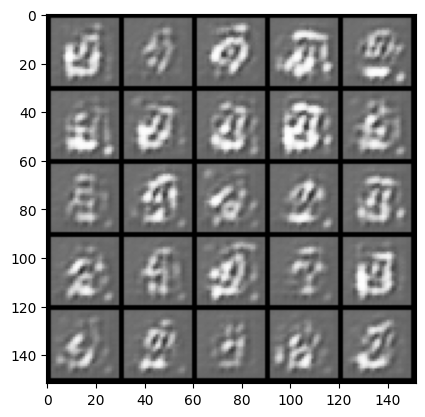

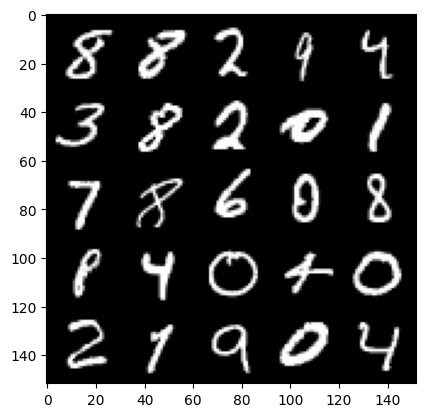

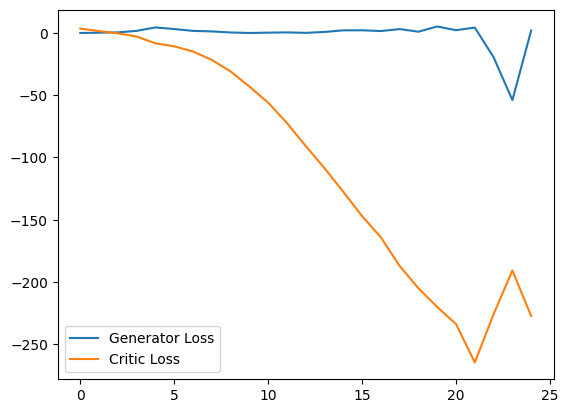

real: 327.67852783203125, fake: -20.99391746520996, regularization: 23.858489990234375
crit_loss: torch.Size([]) -324.81396484375
real: 336.78863525390625, fake: -15.032330513000488, regularization: 25.836551666259766
crit_loss: torch.Size([]) -325.9844055175781
real: 339.5433349609375, fake: -15.873504638671875, regularization: 31.507247924804688
crit_loss: torch.Size([]) -323.90960693359375
real: 338.67498779296875, fake: -19.417144775390625, regularization: 25.59478759765625
crit_loss: torch.Size([]) -332.4973449707031
real: 338.91748046875, fake: -18.2674560546875, regularization: 23.554563522338867
crit_loss: torch.Size([]) -333.63037109375
Epoch 2 : 3.362264394760132s Generator Loss: 18.165639877319336 Discriminator Loss: -328.16713867187497
real: 327.4918212890625, fake: -15.07862663269043, regularization: 23.331207275390625
crit_loss: torch.Size([]) -319.2392272949219
real: 340.8809814453125, fake: -14.608707427978516, regularization: 22.92852020263672
crit_loss: torch.Size([])

  0%|          | 0/469 [00:00<?, ?it/s]

real: 175.4190216064453, fake: 12.848344802856445, regularization: 90.45419311523438
crit_loss: torch.Size([]) -72.11648559570312
real: 282.892578125, fake: -21.22046661376953, regularization: 76.27873229980469
crit_loss: torch.Size([]) -227.8343048095703
real: 456.3865966796875, fake: 27.61626625061035, regularization: 48.078861236572266
crit_loss: torch.Size([]) -380.69146728515625
real: 530.823486328125, fake: 90.2135009765625, regularization: 60.5079460144043
crit_loss: torch.Size([]) -380.10205078125
real: 527.6968383789062, fake: 71.86573028564453, regularization: 56.832427978515625
crit_loss: torch.Size([]) -398.9986877441406
Epoch 3 : 0.10670304298400879s Generator Loss: -51.62727355957031 Discriminator Loss: -291.94859924316404
real: 532.7544555664062, fake: 171.80511474609375, regularization: 53.48079299926758
crit_loss: torch.Size([]) -307.4685363769531
real: 507.5986022949219, fake: 96.75816345214844, regularization: 51.558258056640625
crit_loss: torch.Size([]) -359.2821960

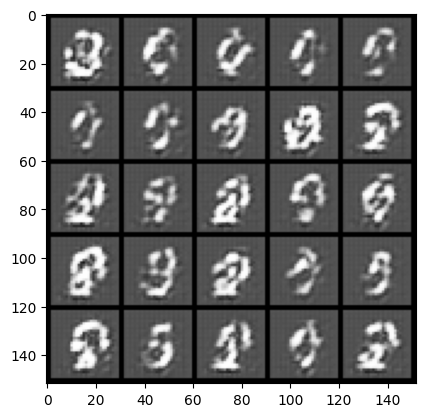

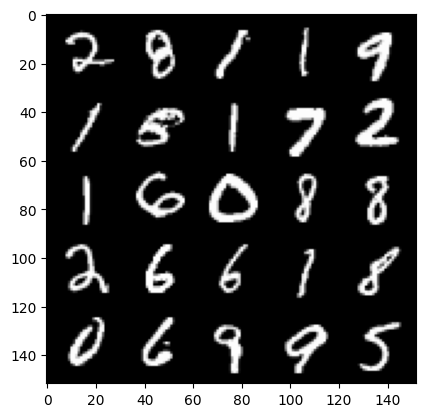

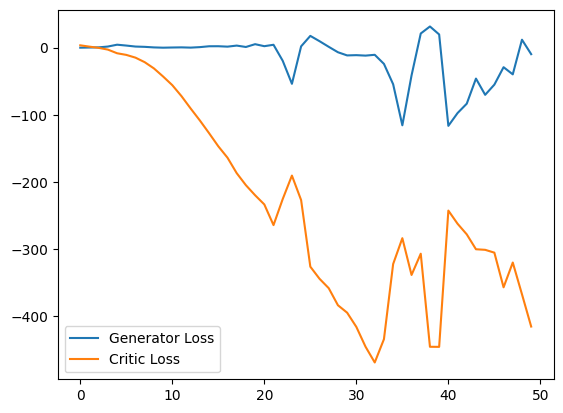

real: 435.3927001953125, fake: 82.3309326171875, regularization: 55.81917190551758
crit_loss: torch.Size([]) -297.2425842285156
real: 513.357177734375, fake: 108.73017120361328, regularization: 52.54574203491211
crit_loss: torch.Size([]) -352.0812683105469
real: 561.7369995117188, fake: 138.41049194335938, regularization: 64.65762329101562
crit_loss: torch.Size([]) -358.66888427734375
real: 561.8009643554688, fake: 133.17938232421875, regularization: 56.71781539916992
crit_loss: torch.Size([]) -371.9037780761719
real: 520.467529296875, fake: 63.05234909057617, regularization: 72.87726593017578
crit_loss: torch.Size([]) -384.5379333496094
Epoch 3 : 6.163436651229858s Generator Loss: -81.23764038085938 Discriminator Loss: -352.88688964843743
real: 429.5762939453125, fake: 84.29936218261719, regularization: 67.30987548828125
crit_loss: torch.Size([]) -277.967041015625
real: 520.981689453125, fake: 121.83939361572266, regularization: 71.94326782226562
crit_loss: torch.Size([]) -327.1990356

  0%|          | 0/469 [00:00<?, ?it/s]

real: 238.0504150390625, fake: 92.13960266113281, regularization: 56.77613067626953
crit_loss: torch.Size([]) -89.13468170166016
real: 442.4797058105469, fake: 231.04550170898438, regularization: 62.54289627075195
crit_loss: torch.Size([]) -148.8913116455078
real: 483.6812744140625, fake: 245.54421997070312, regularization: 88.51377868652344
crit_loss: torch.Size([]) -149.62327575683594
real: 449.360595703125, fake: 173.17987060546875, regularization: 82.00025939941406
crit_loss: torch.Size([]) -194.1804656982422
real: 439.3614501953125, fake: 164.47323608398438, regularization: 49.815574645996094
crit_loss: torch.Size([]) -225.0726318359375
Epoch 4 : 0.11043834686279297s Generator Loss: -142.06712341308594 Discriminator Loss: -161.3804733276367
real: 377.47869873046875, fake: 161.1949005126953, regularization: 59.35456085205078
crit_loss: torch.Size([]) -156.92922973632812
real: 426.482666015625, fake: 163.56106567382812, regularization: 63.645790100097656
crit_loss: torch.Size([]) -1

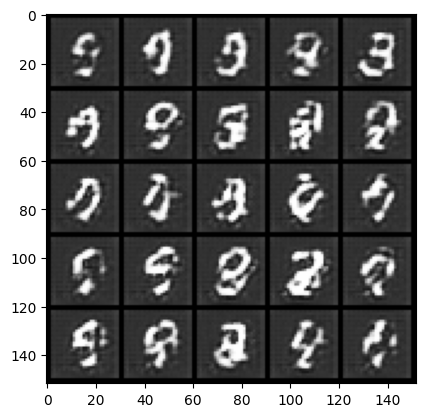

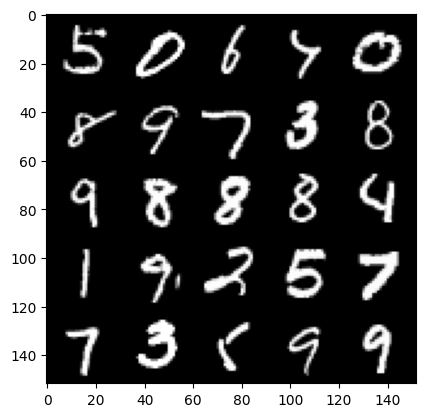

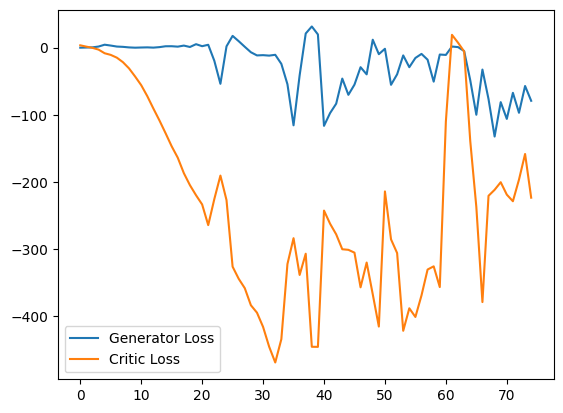

real: 289.9329833984375, fake: 36.214317321777344, regularization: 97.23696899414062
crit_loss: torch.Size([]) -156.481689453125
real: 400.03570556640625, fake: 33.683990478515625, regularization: 73.46353149414062
crit_loss: torch.Size([]) -292.88818359375
real: 357.93524169921875, fake: 18.415355682373047, regularization: 92.65052795410156
crit_loss: torch.Size([]) -246.86936950683594
real: 477.39599609375, fake: 144.47891235351562, regularization: 79.02455139160156
crit_loss: torch.Size([]) -253.8925323486328
real: 295.3360595703125, fake: -54.245941162109375, regularization: 168.06663513183594
crit_loss: torch.Size([]) -181.51536560058594
Epoch 4 : 8.760077238082886s Generator Loss: -294.45458984375 Discriminator Loss: -226.32942810058591
real: 546.64990234375, fake: 305.80401611328125, regularization: 310.8597412109375
crit_loss: torch.Size([]) 70.01385498046875
real: 369.6297607421875, fake: 100.14402770996094, regularization: 133.0294647216797
crit_loss: torch.Size([]) -136.4562

  0%|          | 0/469 [00:00<?, ?it/s]

real: 35.09796905517578, fake: 29.437179565429688, regularization: 227.12631225585938
crit_loss: torch.Size([]) 221.46551513671875
real: 23.925830841064453, fake: 31.42056655883789, regularization: 243.91905212402344
crit_loss: torch.Size([]) 251.41378784179688
real: 7.948273658752441, fake: -36.89240264892578, regularization: 388.12103271484375
crit_loss: torch.Size([]) 343.2803649902344
real: 20.46169090270996, fake: -9.48080062866211, regularization: 238.63160705566406
crit_loss: torch.Size([]) 208.68911743164062
real: -0.3860800266265869, fake: -51.65440368652344, regularization: 426.9227294921875
crit_loss: torch.Size([]) 375.6544189453125
Epoch 5 : 0.10857129096984863s Generator Loss: -61.97076416015625 Discriminator Loss: 280.10064086914065
real: 167.18685913085938, fake: 232.73855590820312, regularization: 432.8160095214844
crit_loss: torch.Size([]) 498.3677062988281
real: 62.293251037597656, fake: -54.507423400878906, regularization: 788.77392578125
crit_loss: torch.Size([]) 6

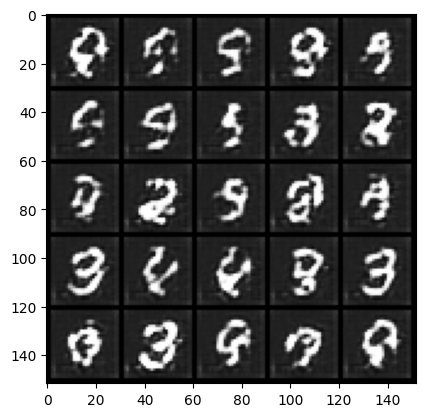

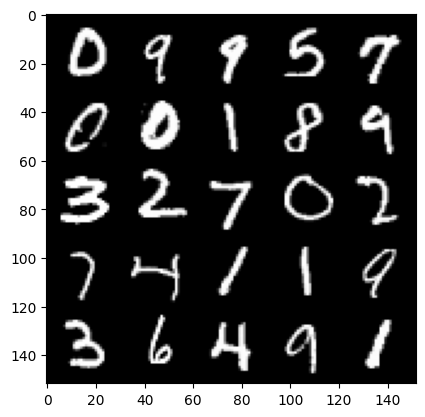

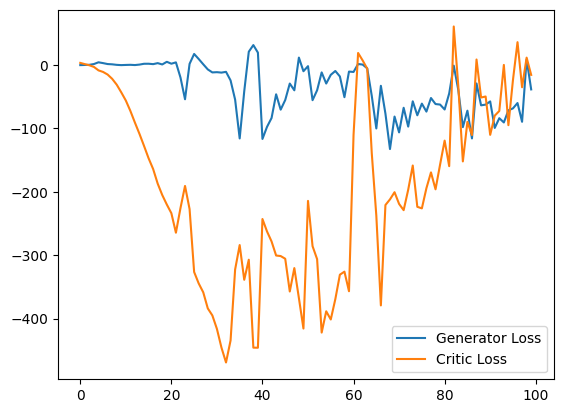

real: 173.53421020507812, fake: 65.34451293945312, regularization: 129.88381958007812
crit_loss: torch.Size([]) 21.694122314453125
real: 224.7166748046875, fake: 103.09764099121094, regularization: 60.843589782714844
crit_loss: torch.Size([]) -60.77544403076172
real: 254.30368041992188, fake: 122.35630798339844, regularization: 169.91998291015625
crit_loss: torch.Size([]) 37.97261047363281
real: 246.09854125976562, fake: 104.43356323242188, regularization: 70.83529663085938
crit_loss: torch.Size([]) -70.82968139648438
real: 253.8863525390625, fake: 102.941162109375, regularization: 58.31427764892578
crit_loss: torch.Size([]) -92.63091278076172
Epoch 5 : 13.363405466079712s Generator Loss: -105.36167907714844 Discriminator Loss: -32.91386108398437
real: 264.76483154296875, fake: 115.72457885742188, regularization: 315.9863586425781
crit_loss: torch.Size([]) 166.94610595703125
real: 208.19223022460938, fake: 51.02482604980469, regularization: 252.4595947265625
crit_loss: torch.Size([]) 9

  0%|          | 0/469 [00:00<?, ?it/s]

real: 10.134732246398926, fake: 4.879446029663086, regularization: 20.760080337524414
crit_loss: torch.Size([]) 15.504794120788574
real: 10.137051582336426, fake: 5.009648323059082, regularization: 19.656620025634766
crit_loss: torch.Size([]) 14.529216766357422
real: 10.080108642578125, fake: 4.928928852081299, regularization: 16.38199806213379
crit_loss: torch.Size([]) 11.230817794799805
real: 10.085168838500977, fake: 4.825932025909424, regularization: 18.135665893554688
crit_loss: torch.Size([]) 12.876428604125977


KeyboardInterrupt: 

In [17]:
import matplotlib.pyplot as pltk, time

cur_step = 0
generator_losses = []
critic_losses = []
for epoch in range(n_epochs):
    start = time.time()
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            ### Update critic ###
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)
        
        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]
        print(f"Epoch {epoch + 1} : {time.time()-start}s Generator Loss: {gen_loss.item()} Discriminator Loss: {mean_iteration_critic_loss}")
        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()

        cur_step += 1
